In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import integrate
import corner
import theano.tensor as tt
%matplotlib inline

In [2]:
ckms = 3.0e5 # speed of light in km/s 
rho_crit0 = 2.7751973751261264e11 # rho_crit(z=0) in units of h^-1 Msun/ h^-3 Mpc^3
G = 4.3e-9 # G in units of Mpc/Msun /(km/s)^2
Omega_m = 0.27
Omega_L = 1. - Omega_m #assumes flatn
sigmashear = 0.3
zlens = 0.245
zsource = 1.0

In [3]:
def E(z):
        """
        Calculates the dimensionless Hubble function.

        Parameters:
        ----------
        z : redshift

        Returns:
        ----------
        E(z) : Dimensionless Hubble function E(z)=H(z)/H0
        """
        E = np.sqrt(Omega_m*(1.+z)**3 + Omega_L)
        return E

def angular_distance(z):
        """
        Calculates angular diameter distances. Assumes a fixed LCDM cosmology
        defined in the Cosmology class.

        Parameters:
        ----------
        z : redshift

        Returns :
        ----------
        d_A(z) : angular diameter distance in Mpc/h
        """
        integral, error = integrate.quad(integrand_angular_distance,0.,z,epsrel=1e-4)
        d_A = integral * ckms*1e-2/(1.+z)
        return d_A
def integrand_angular_distance(z):
        """
        Integrand for the angular diameter distance calculation.

        Parameters:
        ----------
        z : redshift

        Returns:
        ----------
        1./E(z) : Inverse dimensionless Hubble function 1./E(z)=H0/H(z)
        """
        return 1./E(z)

def Sigma_critical(z_lens,z_source):
        """
        Calculates the critical surface density.

        Parameters:
        ----------
        z_lens    : lens redshift
        z_source  : source redshift

        Returns:
        ----------
        Sigmac : critical surface density
        """
        D_source = angular_distance(z_source)
        D_lens = angular_distance(z_lens)
        D_lens_source = D_source - (1.0+z_lens)*D_lens/(1.+z_source)    
        Sigmac = ckms**2*D_source/D_lens/D_lens_source/np.pi/G/4.
        return Sigmac

def g_less(x):
        """
        Auxiliary function g(x) for shear calculation, assumes x < 1.

        Parameters:
        ----------
        x : array_like, dimensionless radial distance between source and lens

        Returns:
        ----------
        result : array_like with same shape as x, analytic shear
                 integral for a NFW density profile
        """
        arctan = tt.arctanh(np.sqrt((1.-x)/(1.+x))) 
        x_sq = x*x
        term1 = 8.*arctan/x_sq/tt.sqrt(1.-x**2) + 4./x_sq*tt.log(x/2.) - 2./(x_sq-1)
        result = (term1 + 4.*arctan/(x_sq-1.)/tt.sqrt(1.-x_sq))
        return result

def g_larger(x):
        """
        Auxiliary function g(x) for shear calculation, assumes x > 1.

        Parameters:
        ----------
        x : array_like, dimensionless radial distance between source and lens

        Returns:
        ----------
        result : array_like with same shape as x, analytic shear
                 integral for a NFW density profile
        """
        arctan = tt.arctan(np.sqrt((x-1.)/(1.+x))) 
        x_sq = x*x
        term1 = 8.*arctan/x_sq/tt.sqrt(x**2-1.) + 4./x_sq*np.log(x/2.) - 2./(x_sq-1)
        result = (term1 + 4.*arctan/(x_sq-1.)**1.5)
        return result

def scale_radius_nfw(M200,c200):
        """
        Calculates scale radius of a NFW profile.

        Parameters:
        ----------
        M200 : Mass of the lens enclosed within a radius r200 where the mean density is 200 times
               larger than the background matter density
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        r_s : scale radius
        """            
        r_s = (3.0*M200/800.0/np.pi/rho_crit_zlens/c200**3)**(1./3.)
        return r_s

def delta_c(c200):
        """
        Calculates the central density contrast for a NFW profile.

        Parameters:
        ----------
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        delta_c : central density contrast 
        """    
        delta_c = 200.*c200**3/(np.log(1.+c200) - c200/(1.+c200))/3.
        return delta_c

In [4]:
rho_crit_zlens= rho_crit0 * E(zlens)**2

data = np.loadtxt('./data/halo5.tab')
print(data.shape)

(627656, 14)


In [5]:
THETADAT = data[:,3] # angular distance in arcmin
SHEARDAT = data[:,5] # measured shear signal
RDAT = angular_distance(zlens)*THETADAT*np.pi/180.0/60.0 # physical distance
        
DATA = np.zeros((THETADAT.size,2))
DATA[:,0] = RDAT
DATA[:,1] = SHEARDAT

In [6]:
sigma_cric = Sigma_critical(zlens, zsource)
log10M = 15
c =2.5
r_s = (3.*10.**log10M/800.0/np.pi/rho_crit_zlens/c**3) ** (1./3.)
x = RDAT/r_s
delta_C = 200.*c**3/(tt.log(1.+c) - c/(1.+c))/3.
shear = r_s * delta_C * rho_crit_zlens / sigma_cric
gless = g_less(x)
glarg = g_larger(x)

In [7]:
sigma_cric = Sigma_critical(zlens, zsource)
print(sigma_cric)
with pm.Model() as lensing_model:
    log10M = pm.Uniform('log10M', lower=14,upper=16)
    c = pm.Uniform('C',lower=2,upper=4)
    r_s = (3.*10.**log10M/800.0/np.pi/rho_crit_zlens/c**3) ** (1./3.)
    x = RDAT/r_s
    delta_C = 200.*c**3/(tt.log(1.+c) - c/(1.+c))/3.
    shear = r_s * delta_C * rho_crit_zlens / sigma_cric
    gless = g_less(x)
    glarg = g_larger(x)
    #switchpoint = pm.Deterministic('switchpoint', x)
    g = pm.math.switch(x < 1, gless, glarg)
    mu = shear*g
    y = pm.Normal('y',mu=mu,sd=sigmashear,observed=SHEARDAT)

4225278190963054.0


In [13]:
with lensing_model:
    advi = pm.ADVI(random_state=1234)
    #traces = pm.fit(n=500, method='advi')

In [14]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)

In [15]:
with lensing_model:
    approx = advi.fit(n=50000,obj_optimizer=pm.adam(learning_rate=5e-4),callbacks=[tracker,pm.callbacks.CheckParametersConvergence(diff='absolute')])

Average Loss = 1.3492e+05:  35%|███▍      | 17399/50000 [18:14<34:09, 15.90it/s]
Convergence achieved at 17400
Interrupted at 17,399 [34%]: Average Loss = 1.3495e+05


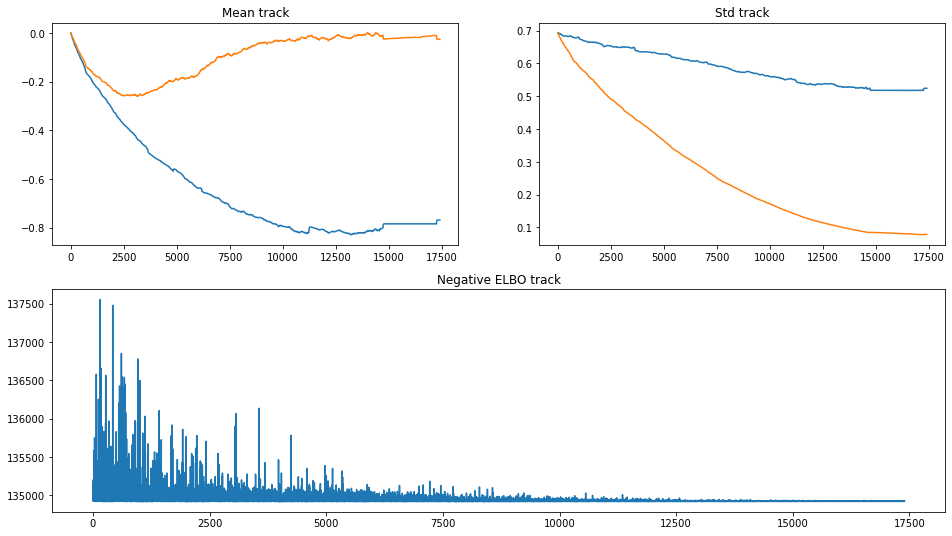

In [16]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track')
plt.savefig('cosine_converg.png')

In [17]:
with lensing_model:
    param = pm.sample_approx(approx,draws=3000)

/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


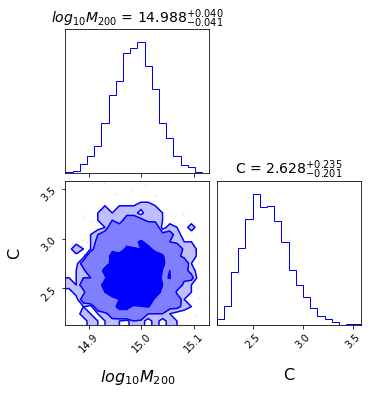

In [18]:
dn = np.asarray([param['log10M'],param['C']]).T
corner.corner(dn, labels=["$log_{10}M_{200}$", "C"] ,levels=(0.68,0.95,0.99),color = 'b',alpha=0.1,fill_contours = 1,show_titles=True,title_fmt='.3f',max_n_ticks = 3, title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 16},contour_kwargs={"color": 'r'})
plt.savefig('advi_cluster.png')

In [29]:
# import pickle
# with open('lensing_model_vi.pkl', 'wb') as buff:
#     pickle.dump({'model': lensing_model, 'trace': param}, buff)

In [30]:
# with open('lensing_model_vi.pkl', 'rb') as buff:
#     data = pickle.load(buff)  

# bm, t = data['model'], data['trace']

# MCMC

In [8]:
mcmc = np.load('lensing.pkl', allow_pickle=True)

/home/geethu/miniconda3/envs/vipaperenv/lib/python3.7/site-packages/corner/corner.py:806: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


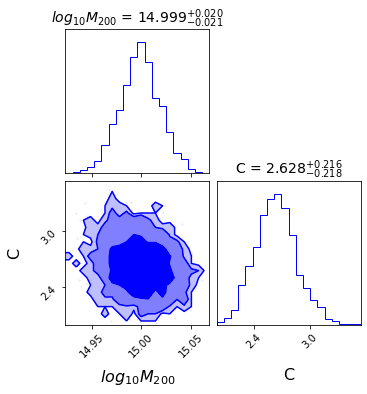

In [12]:
dn = np.asarray([mcmc[:,0],mcmc[:,1]]).T
corner.corner(dn, labels=["$log_{10}M_{200}$", "C"] ,levels=(0.68,0.95,0.99),color = 'b',alpha=0.1,fill_contours = 1,show_titles=True,title_fmt='.3f',max_n_ticks = 3, title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 16},contour_kwargs={"color": 'r'})
plt.savefig('mcmc_cluster.png')